<h1> Lecture 27

Data Science 8, Summer 2021 </h1>

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in Data 8.

def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='r'):
    y = x*slope + intercept
    plots.plot(x, y, color=color)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_table(r):
    """
    Generate a table of 1000 x,y data points in standard units
    whose correlation is approximately equal to r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

## Slope & Intercept

In [3]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

In [4]:
def slope(t, x, y):
    r = correlation(t, x, y)
    sd_x = np.std(t.column(x))
    sd_y = np.std(t.column(y))
    return r*sd_y/sd_x
    
def intercept(t, x, y):
    mean_x = np.mean(t.column(x))
    mean_y = np.mean(t.column(y))
    return mean_y - slope(t, x, y) * mean_x

In [5]:
# r_table generates data for x and y such that the correlation of x and y is 0.5
example = r_table(0.5)

In [6]:
example

x,y
0.0912047,-0.926244
1.09128,0.321783
-1.94697,-0.701279
-1.38635,-0.535148
-2.29649,-0.385796
2.40983,2.49743
1.72784,1.1729
2.20456,3.62415
0.794828,0.344429
0.976421,1.80645


What do you expect the slope and intercept to be?

In [7]:
slope(example, 'x', 'y')

0.5022638281625915

In [8]:
intercept(example, 'x', 'y')

0.03801479544542581

## Discussion Question

In [9]:
mean_midterm = 70
sd_midterm = 10

mean_final = 50
sd_final =12
r = 0.75

slope_ex = r * sd_final/sd_midterm
int_ex = mean_final - slope_ex * mean_midterm

slope_ex * 90 + int_ex

68.0

## Movies data

Let's predict Domestic Gross from Budget

In [10]:
movies = Table.read_table('movies.csv')
movies.show(11)

Year,Title,Distributor,Domestic Gross,Budget,Category,Yanay Watched,Katherine Watched
2021,A Quiet Place Part II*,Paramount,136,61,Horror,0,0
2021,Godzilla vs. Kong*,Warner Bros.,100,177.5,Other,1,0
2021,Cruella*,Disney,71,150,Other,0,0
2021,F9*,Universal,70,200,Other,0,0
2021,The Conjuring: The Devil Made Me Do It*,Warner Bros.,59,39,Horror,0,0
2021,Raya and the Last Dragon*,Disney,54,100,Animated,1,0
2021,Tom & Jerry*,Warner Bros.,46,79,Other,0,0
2021,Mortal Kombat*,Warner Bros.,42,55,Other,1,0
2021,Peter Rabbit 2: The Runaway*,Sony Pictures,29,107.9,Other,0,0
2021,Wrath of Man*,MGM,27,40,Other,0,0


In [11]:
cash = movies.select("Budget", "Domestic Gross")
cash

Budget,Domestic Gross
61,136
177.5,100
150,71
200,70
39,59
100,54
79,46
55,42
107.9,29
40,27


First, let's visualize the data

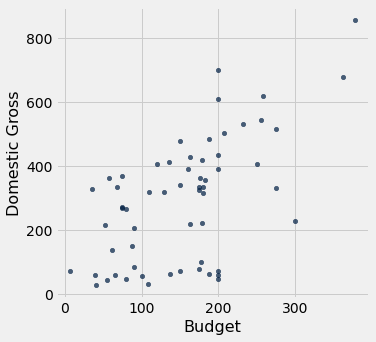

In [12]:
cash.scatter('Budget','Domestic Gross')

Let's use nearest neighbors regression

In [13]:
def predict_gross_nn(b):
    """Return a prediction of the domestic gross for a movie 
    with a budget of b
    
    The prediction is the average domestic gross of the movies
    whose budget is in the range b plus or minus $20 million dollars.
    """
    
    close_points = cash.where('Budget', are.between(b-20, b+20))
    return np.mean(close_points.column("Domestic Gross"))   

In [14]:
cash_with_predictions = cash.with_column(
    'NN Prediction', cash.apply(predict_gross_nn, 'Budget')
    )

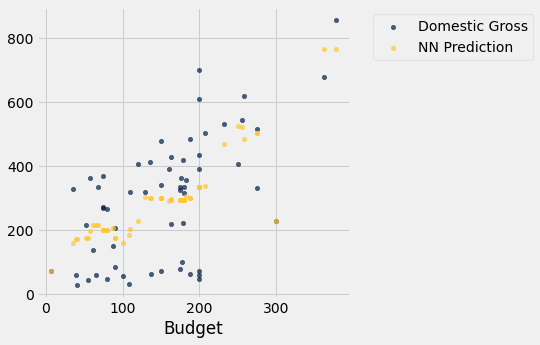

In [15]:
cash_with_predictions.scatter('Budget')

Let's see our prediction for Domestic Gross for a movie with a Budget of $200 million

In [16]:
nn_prediction = predict_gross_nn(200)
nn_prediction

335.84615384615387

Now let's try linear regression

In [17]:
cash_slope = slope(cash, "Budget", "Domestic Gross")
cash_intercept = intercept(cash, "Budget", "Domestic Gross")
cash_slope, cash_intercept

(1.475518209961451, 68.05732993237851)

Let's see our prediction for Domestic Gross for a movie with a Budget of $200 million using linear regression.

In [18]:
linear_prediction = cash_slope * 200 + cash_intercept
linear_prediction

363.16097192466873

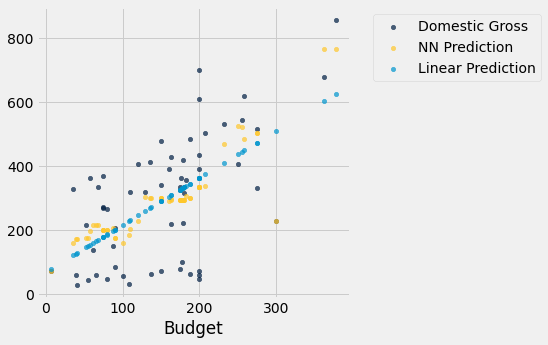

In [19]:
linear_predictions = cash_slope * cash.column("Budget") + cash_intercept
cash_with_predictions.with_column("Linear Prediction", linear_predictions).scatter("Budget")

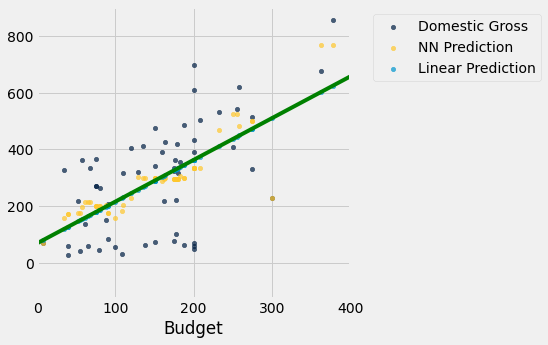

In [20]:
cash_with_predictions.with_column("Linear Prediction", linear_predictions).scatter("Budget")

# plot a line (out of scope)
# draw line is a function defined at the top of the notebook
draw_line(cash_slope, cash_intercept, make_array(-100, 500), color='g')
plots.xlim([0, 400]);

## Least Squares

### Error in Estimation

In [21]:
def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)

In [22]:
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5)

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


In [23]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


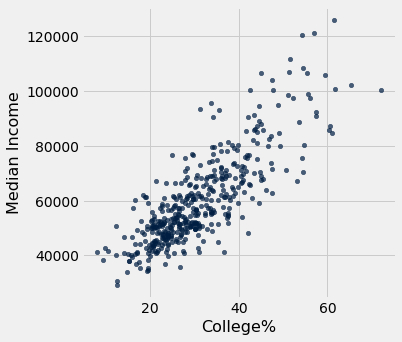

In [24]:
demographics.scatter('College%', 'Median Income')

Slide: Discussion question

In [25]:
correlation(demographics, 'College%', 'Median Income')

0.8184648517141335

In [26]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

In [27]:
def fitted_values(t, x, y):
    """Return an array of the regressions estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

In [28]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

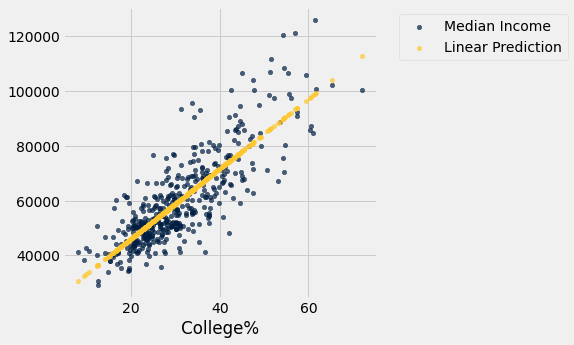

In [29]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

There are some errors!

In [30]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [31]:
demographics.with_column('Error', errors)

Median Income,College%,Linear Prediction,Error
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


Should we look at the average of errors?

In [32]:
np.mean(errors)

6.356008950321154e-13

In [33]:
np.mean(errors ** 2) ** 0.5

9398.515588571281

We call this value the root mean square error.

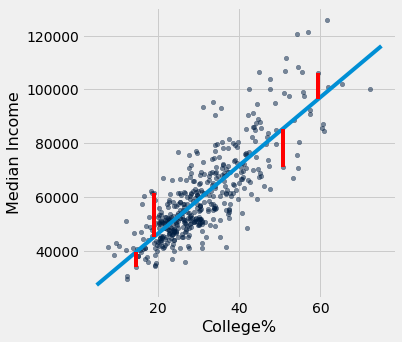

In [34]:
# function defined at the beginning of this section
# uses 4 points, draws a red line from point to it's predicted value 
# to visualize the error
demographics_errors(regression_slope, regression_intercept)

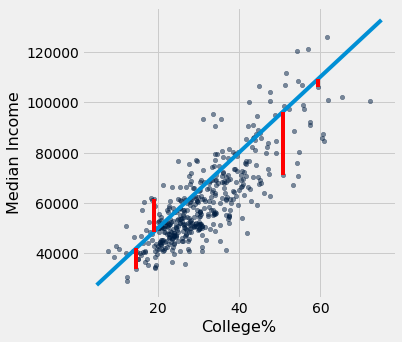

In [35]:
# takes any slope, any intercept

demographics_errors(1500, 20000)

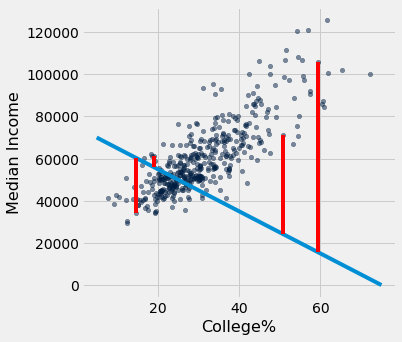

In [36]:
demographics_errors(-1000, 75000)

Slide: Error in Estimation

### Root Mean Square Error ###

In [37]:
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

Root mean squared error: 30247.88


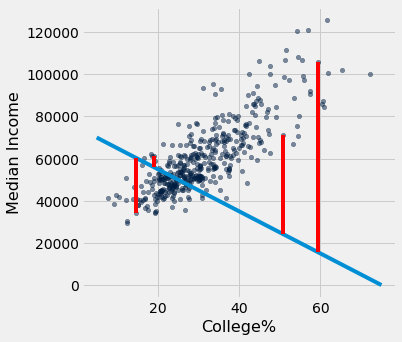

In [38]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 11559.09


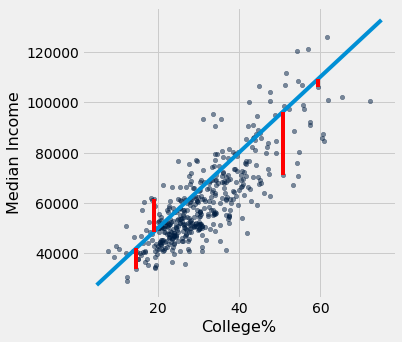

In [39]:
show_demographics_rmse(1500, 20000)

Root mean squared error: 9398.52


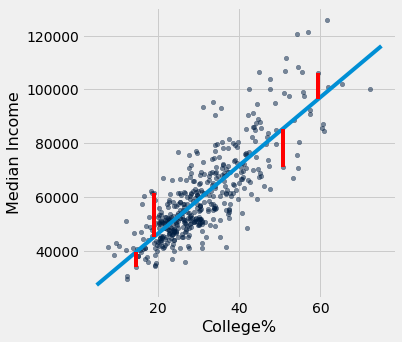

In [40]:
show_demographics_rmse(regression_slope, regression_intercept)

Slide: Least Squares Line

### Numerical Optimization ###

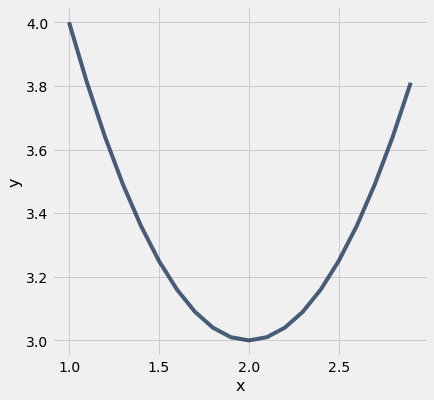

In [41]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [42]:
def f(x):
    return ((x-2)**2) + 3

In [43]:
minimize(f)

1.9999999946252267

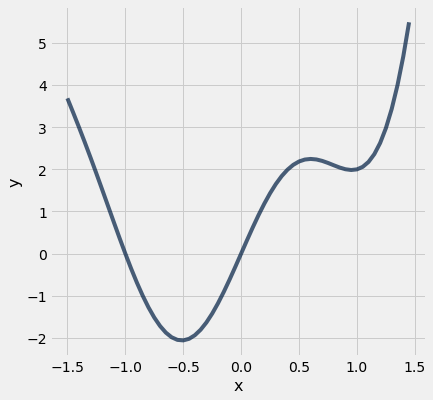

In [44]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [45]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [46]:
minimize(complicated_function)

-0.5126437620940081

### Minimizing RMSE ###

In [47]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate) ** 2)) ** 0.5

In [48]:
demographics_rmse(1500, 20000)

11559.086490075999

In [49]:
demographics_rmse(-1000, 75000)

30247.883767944502

In [50]:
minimize(demographics_rmse)

array([ 1270.70168805, 20802.57933807])

In [51]:
make_array(regression_slope, regression_intercept)

array([ 1270.70168946, 20802.57776668])

### Nonlinear Regression ###

In [52]:
shotput = Table.read_table('shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


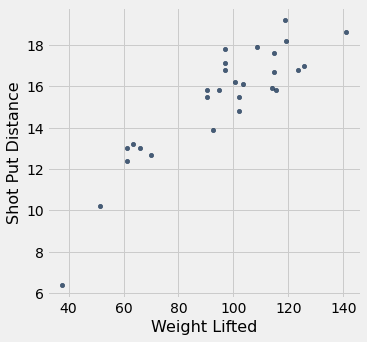

In [53]:
shotput.scatter('Weight Lifted')

In [54]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [55]:
best_line = minimize(shotput_linear_rmse)
best_line

array([0.09834382, 5.95962883])

In [56]:
weights = shotput.column(0)

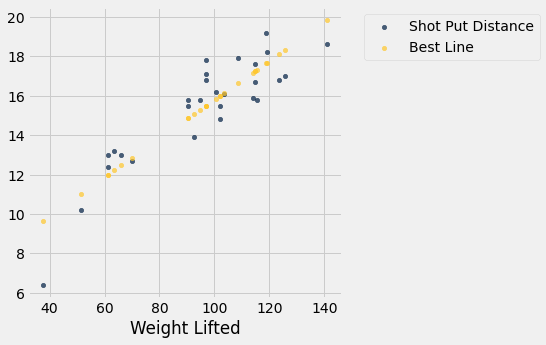

In [57]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [58]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [59]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([-1.04003731e-03,  2.82706003e-01, -1.53167618e+00])

In [60]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [61]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

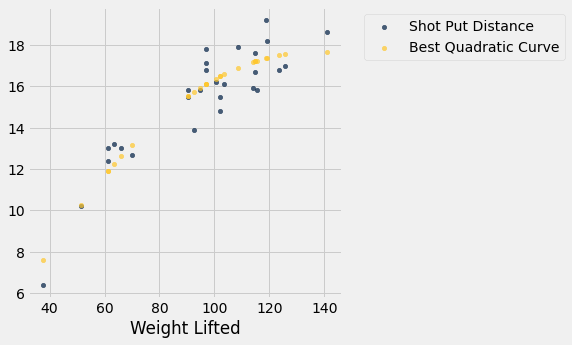

In [62]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)